In [60]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()
# read data ignore last col
import py_vncorenlp
import os
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True



if 'pwd' not in locals():
    from transformers import PhobertTokenizer, AutoModel
    from transformers import DataCollatorForTokenClassification
    pwd = Path(os.getcwd())
    save_dir = pwd / 'models'
    rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=str(save_dir))
    os.chdir(pwd)
    seed_everything(25)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

/home/ubuntu/anaconda3/envs/atg/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-08-15 15:37:55 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [71]:
data = pd.read_csv('data - data.csv', usecols=range(0, 3))
data['wseg'] = data['comment'].apply(lambda x : " ".join(simple_preprocess(" ".join(rdrsegmenter.word_segment(x)))))
data.sample(10)


,comment,label,rate,wseg
6452,Shop phục vụ tốt.,POS,4,shop phục_vụ tốt
26367,"Bé nhỏ cũng có thể dắt xe, nhấc xe lên để chơi.",NEU,3,bé_nhỏ cũng có_thể dắt xe nhấc xe lên để chơi
29602,Áo không giống hình sản phẩm lỗi lừa đảo.,NEG,1,áo không giống hình sản_phẩm lỗi lừa_đảo
19747,"ba lô phù hợp vs giá tiên, như hình.",NEU,3,ba_lô phù_hợp vs giá tiên như hình
1432,Rất ok mua hoài vẫn ok.,POS,5,rất ok mua hoài vẫn ok
445,5 sao nha!,POS,5,sao nha
19210,Đóng gói sản phẩm rất đẹp và chắc chắn.,POS,5,đóng_gói sản_phẩm rất đẹp và chắc_chắn
12179,Ưng quá.,POS,5,ưng quá
11598,Thời gian giao hàng rất nhanh.Hàng ok.,POS,4,thời_gian giao hàng rất nhanh hàng ok
8113,K biết cái này tác dụng thơm ở đâu.,NEG,1,biết cái này tác_dụng thơm đâu


<Axes: xlabel='label', ylabel='count'>

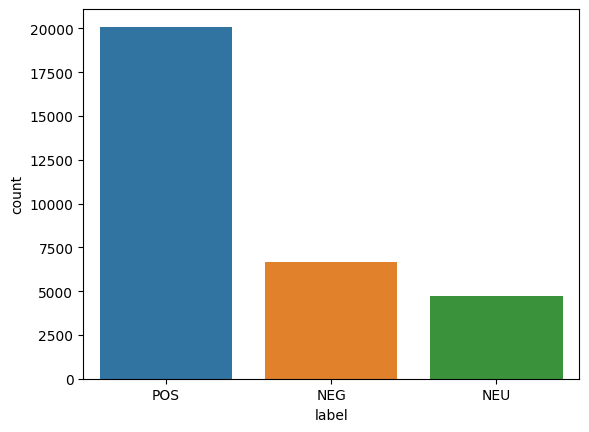

In [6]:
sns.countplot(x='label', data=data)

<Axes: xlabel='rate', ylabel='count'>

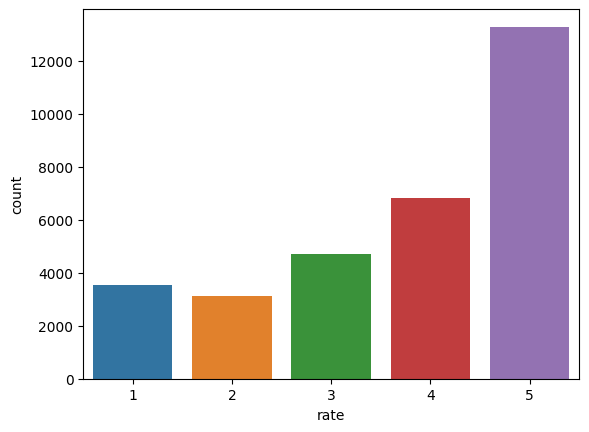

In [8]:
sns.countplot(x='rate', data=data)

In [68]:
log_svm_path ='log_svm_acc.log'
logs = open(log_svm_path).readlines()[1:]
results = []
for line in logs:
    dict_ = {}
    for token in ['C','gamma','kernel','score']:
        token = token + '='
        if token == 'kernel=':
            result = line.split(token)[1].split(';')[0]
        else:
            t = line.split(token)[1]
            flag = False
            result = ''
            for char in t:
                if char.isdigit():
                    flag = True
                if flag:
                    if (char == '.') or (char.isdigit()):
                        result += char  
                    else:
                        break
            result = float(result)
        dict_[token[:-1]] = result
    results.append(dict_)

In [69]:
import pandas as pd
results_df = pd.DataFrame(results)
scores_mean = results_df.groupby(['C','gamma','kernel']).mean()
scores_std = results_df.groupby(['C','gamma','kernel']).std()
scores_mean_dict = dict(scores_mean.score)
scores_std_dict = dict(scores_std.score)


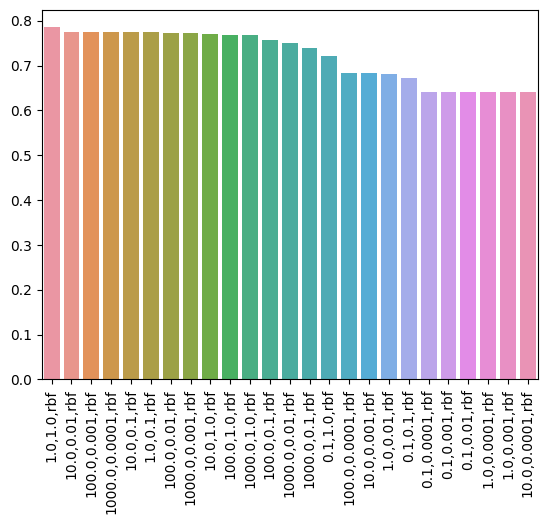

In [70]:
sorted_ = sorted(scores_mean_dict.items(),key = lambda x: -x[1])
Y_axis = [_[1] for _ in sorted_]
X_axis = [",".join(str(_) for _ in k) for k,v in sorted_]
sns.barplot(x= X_axis,y=Y_axis)
#rotate x axis
plt.xticks(rotation=90);


In [74]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(tokenizer = lambda x : x.split(' '))
corpus  = data['wseg'].tolist()
X = vectorizer.fit_transform(corpus)



Y = data['label'].tolist()
le = preprocessing.LabelEncoder()
le.fit(Y)
Y = le.transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

In [77]:
from sklearn.svm import SVC
svm = SVC(C = 10, gamma=0.1, kernel='rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred,  target_names=['POS','NEU','NEG']))

              precision    recall  f1-score   support

         POS       0.66      0.75      0.70      1328
         NEU       0.45      0.22      0.30       979
         NEG       0.85      0.92      0.88      3985

    accuracy                           0.77      6292
   macro avg       0.65      0.63      0.63      6292
weighted avg       0.75      0.77      0.75      6292

